# Homework 2 - The Best Books of All Times

To load the datatset we decided to use pyspark and then use pandas to answer the research questions, the code below is used to create the session.

## Setting up environment and Loading data from json file into dataframe

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [2]:
# spark is an existing SparkSession 
spark

In [7]:
# import packages
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.functions import col, trim, length, to_date, year, month, collect_list, max, countDistinct, when
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

In [5]:
# Load the data into DataFrames
df_lighter_books = spark.read.json("lighter_books.json")
df_lighter_authors = spark.read.json("lighter_authors.json")
df_list = spark.read.json("list.json")

In [8]:
# Views of the files
df_lighter_books.createOrReplaceTempView("lighter_books")
df_lighter_authors.createOrReplaceTempView("lighter_authors")

In [6]:
# Choosing a style for our plots
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Serif'
our_colors = ["#1f487e","#1d3461", "#376996", "#6290c8", "#829cbc"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=our_colors) #for the piechart

# [RQ1] Exploratory Data Analysis (EDA) 
We have two main files in which our data are saved, "lighter_authors.json" and "lighter_books.json". 
- To begin the exploratory analysis we start by looking at the first few rows of our datasets. We created the count_columns_type function in order to see how many columns in the dataset contain numeric, categorical, or other type of variables. We also printed out how many rows each dataset has. <br>
Books_lighter has 26 columns and a total of 7027431 rows while Authors_lighter has 12 columns and 351767 rows. <br>
It is also useful to print the list with all the columns of the datasets.

Usually the data cleaning process is done in the exploratory analysis, however, given the size of the dataset we decided to clean the columns of interest when needed. 

In [ ]:
# Dropping duplicates
df_lighter_books = df_lighter_books.dropDuplicates()
df_lighter_authors = df_lighter_authors.dropDuplicates()

In [9]:
# Function to obtain the type of the columns
def count_columns_type(data):
    categorial = 0
    numeric = 0
    other = 0
    from pyspark.sql.types import StringType, DoubleType, LongType
    for col in data.columns:
        c_type = data.schema[col].dataType
        #print(c_type)
        if isinstance(c_type, StringType):
            categorial += 1
            
        elif isinstance(c_type, LongType) or isinstance(c_type,DoubleType):
            numeric += 1
        else:
            other += 1
    print("The number of categorial columns is: ", categorial)
    print("The number of numeric columns is: ", numeric)
    print("The number of other types of columns is: ", other)

In [10]:
# Let's see the head of Books 
books_5 = spark.sql("SELECT (*) FROM lighter_books LIMIT 5").toPandas() # Transofrming the pysparkquery to a pandas dataframe
display(books_5)
print("The total number of columns is:", len(df_lighter_books.columns))
count_columns_type(df_lighter_books)
count_books = spark.sql("SELECT COUNT(*) FROM lighter_books").toPandas()
print("The number of rows in the books file is:" , count_books.iloc[0,0])

,asin,author_id,author_name,authors,average_rating,description,edition_information,format,id,image_url,...,publisher,rating_dist,ratings_count,series_id,series_name,series_position,shelves,text_reviews_count,title,work_id
0,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.50,There is a door at the end of a silent corrido...,US Edition,Paperback,2,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic Inc.,5:1674064|4:664833|3:231195|2:41699|1:16215|to...,2628006,45175,Harry Potter,5,"[(324191, to-read), (52675, currently-reading)...",44716,Harry Potter and the Order of the Phoenix (Har...,2809203
1,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.48,Harry Potter's life is miserable. His parents ...,Library Edition,Hardcover,3,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic Inc,5:4801606|4:1681521|3:623286|2:145898|1:125040...,7377351,45175,Harry Potter,1,"[(63540, fantasy), (57260, favorites), (20889,...",116930,Harry Potter and the Sorcerer's Stone (Harry P...,4640799
2,,1077326,J.K. Rowling,None,4.43,The Dursleys were so mean and hideous that sum...,,Hardcover,4,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic,5:1690166|4:781011|3:313727|2:54687|1:15453|to...,2855044,45175,Harry Potter,2,"[(282341, to-read), (67110, currently-reading)...",55286,Harry Potter and the Chamber of Secrets (Harry...,6231171
3,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.57,"For twelve long years, the dread fortress of A...",,Mass Market Paperback,5,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic Inc.,5:1994597|4:696545|3:212678|2:28915|1:13959|to...,2946694,45175,Harry Potter,3,"[(292815, to-read), (52580, fantasy), (49479, ...",58023,Harry Potter and the Prisoner of Azkaban (Harr...,2402163
4,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.56,Harry Potter is midway through his training as...,First Scholastic Trade Paperback Edition,Paperback,6,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic,5:1808039|4:663849|3:193604|2:27759|1:12425|to...,2705676,45175,Harry Potter,4,"[(287086, to-read), (60111, currently-reading)...",48637,Harry Potter and the Goblet of Fire (Harry Pot...,3046572


The total number of columns is: 26
The number of categorial columns is:  17
The number of numeric columns is:  7
The number of other types of columns is:  2
The number of rows in the books file is: 7027431


In [11]:
# Head of authors data
authors_5 = spark.sql("SELECT (*) FROM lighter_authors LIMIT 5").toPandas()
display(authors_5)
print("The total number of columns is:", len(df_lighter_authors.columns))
count_columns_type(df_lighter_authors)
count_authors = spark.sql("SELECT COUNT(*) FROM lighter_authors").toPandas()
print("The number of rows in the authors file is:" , count_authors.iloc[0,0])

,about,average_rating,book_ids,fans_count,gender,id,image_url,name,ratings_count,text_reviews_count,work_ids,works_count
0,"Douglas Noël Adams was an English author, comi...",4.19,"[386162, 13, 8695, 8694, 6091075, 365, 569429,...",19826,male,4,https://images.gr-assets.com/authors/159137433...,Douglas Adams,2862064,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...",106
1,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",4.02,"[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",16144,male,7,https://images.gr-assets.com/authors/157859752...,Bill Bryson,1417316,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...",75
2,"Jude Fisher is the pseudonym for <a href=""http...",4.53,"[349254, 15222, 14833682, 15221, 18126815, 152...",60,female,10,https://images.gr-assets.com/authors/141145711...,Jude Fisher,56159,352,"[17150, 808427, 20487307, 90550, 25460625, 171...",14
3,James Hamilton-Paterson's work has been transl...,3.79,"[40, 9416484, 12482, 3753106, 26889789, 104764...",72,male,12,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson,3302,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...",45
4,Mark Andrew Watson (born 13 February 1980) is ...,3.60,"[8466327, 15739968, 22756778, 51026133, 260451...",179,male,14,https://images.gr-assets.com/authors/133175379...,Mark Watson,7979,772,"[13330815, 19109351, 42306244, 72694240, 26291...",61


The total number of columns is: 12
The number of categorial columns is:  4
The number of numeric columns is:  6
The number of other types of columns is:  2
The number of rows in the authors file is: 351767


In [12]:
# Let's see the columns of the datasets
df_lighter_books.columns

['asin',
 'author_id',
 'author_name',
 'authors',
 'average_rating',
 'description',
 'edition_information',
 'format',
 'id',
 'image_url',
 'isbn',
 'isbn13',
 'language',
 'num_pages',
 'original_publication_date',
 'publication_date',
 'publisher',
 'rating_dist',
 'ratings_count',
 'series_id',
 'series_name',
 'series_position',
 'shelves',
 'text_reviews_count',
 'title',
 'work_id']

In [13]:
df_lighter_authors.columns

['about',
 'average_rating',
 'book_ids',
 'fans_count',
 'gender',
 'id',
 'image_url',
 'name',
 'ratings_count',
 'text_reviews_count',
 'work_ids',
 'works_count']

We can continue to explore our dataset by doing different things depending on the type of variables we have: <br>
- For numerical variables, statistics such as count, mean, standard deviation, minimum value, and maximum value can be obtained through the describe() function.
- For categorical variables, frequency tables can be constructed in which the absolute frequency of character modes can be seen. <br>
We decided to show them for book format and publisher. The most commonly used formats are Paperback, Hardcover ,ebook, Audio CD and Kindle Edition while the most popular publishers are Book on Demand Ltd , Createspace Independent Publishing Platform, Smashwords Edition Turtleback Books and Books LLC, Wiki Series. 
- For the author dataset we decided to make a barplot for the gender of the authors, we changed the y-axis to logarithmic scale because it was not possible to see graphically the presence of even genders other than male and female.

In [17]:
# Descriptive statistics for numeric variables of books
statistics_num_var_book = df_lighter_books.select("average_rating", "edition_information", "ratings_count", "text_reviews_count").describe().toPandas()
statistics_num_var_book #1 minute to run

,summary,average_rating,edition_information,ratings_count,text_reviews_count
0,count,7027431,7027431,7027431,7027431
1,mean,3.306187915612408,4.2425113324187964E11,19458.609666035853,641.7257807298286
2,stddev,1.4357340879502622,1.8024371813681375E13,160900.7621571502,4169.806199983704
3,min,0.0,,0,0
4,max,5.0,１,7400639,174524


In [15]:
# Descriptive statistics for numeric variables of authors
statistics_num_var_authors = df_lighter_authors.select("average_rating", "fans_count", "ratings_count", "works_count").describe().toPandas()
statistics_num_var_authors #2 sec to run

,summary,average_rating,fans_count,ratings_count,works_count
0,count,351767,351767,351767,351767
1,mean,3.651194313281242,111.61573143586521,4770.586308550831,25.937137366495435
2,stddev,1.2114816423862007,2661.018138865955,97693.95378788888,3066.0828516236857
3,min,-31.0,-33,-41,0
4,max,5.0,766035,27003752,1775176


In [19]:
# Cleaning the columns
df_lighter_books = df_lighter_books.filter(trim(col("format")) != "")
df_lighter_books = df_lighter_books.filter(trim(col("publisher")) != "")
df_lighter_books = df_lighter_books.dropna(subset=["format","publisher"])
df_lighter_books.createOrReplaceTempView("lighter_books") # needed to save the changes in the view

In [20]:
# For categorical variables we can make frequency tables for example abot the format of the books
formats = spark.sql("SELECT format, COUNT(*) FROM lighter_books GROUP BY format ORDER BY COUNT(*) DESC").toPandas()
# The same can be done for the publisher
publishers = spark.sql("SELECT publisher, COUNT(*) FROM lighter_books GROUP BY publisher ORDER BY COUNT(*) DESC").toPandas()
#2 minutes to run

In [21]:
# This is our frequency table to see the count of the most used formats
formats.head(5)

,format,count(1)
0,Paperback,2177540
1,Hardcover,952597
2,ebook,868525
3,Audio CD,117705
4,Kindle Edition,109497


In [22]:
# The same for the most popular publishers
publishers.head(5)

,publisher,count(1)
0,Book on Demand Ltd.,108860
1,Createspace Independent Publishing Platform,89302
2,Smashwords Edition,79087
3,Turtleback Books,58453
4,"Books LLC, Wiki Series",56899


In [23]:
# About the authors we can do a plot to see the distribution of the gender
# Cleaning the colum
df_lighter_authors = df_lighter_authors.filter(trim(col("gender")) != "")
df_lighter_authors = df_lighter_authors.dropna(subset=["gender"])
# Creating a new column to fix the same gender but written in different ways
df_lighter_authors = df_lighter_authors.withColumn("gender_standard", when(col("gender").isin("non-binary", "Nonbinary", "Non-binary", "nonbinary"), "Non-binary").otherwise(col("gender")))
df_lighter_authors.createOrReplaceTempView("lighter_authors") #needed again because the standardized gender
gender_authors = spark.sql("SELECT gender_standard, COUNT(*) FROM lighter_authors GROUP BY gender_standard ORDER BY count(*) DESC").toPandas()
gender_authors.head(5)

# Most of the authors are males, than we have the female authors and then there are a few of other genders

,gender_standard,count(1)
0,male,138179
1,female,109878
2,Non-binary,95
3,genderqueer,28
4,Agender,11


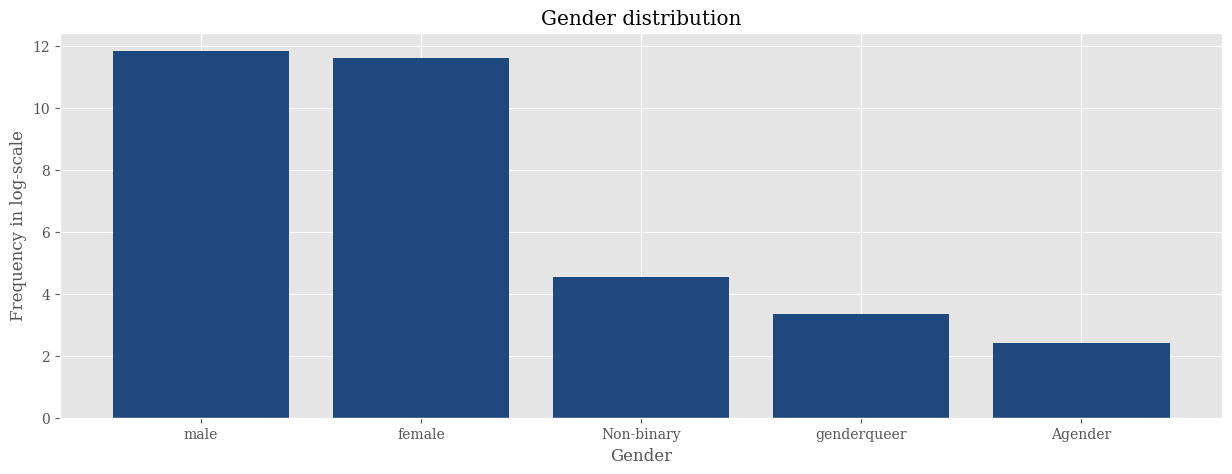

In [24]:
plt.figure(figsize=(15,5))
plt.bar(gender_authors["gender_standard"].head(5),np.log(gender_authors["count(1)"].head(5))) #logaritmic scale to make the differences visible
plt.title('Gender distribution')  
plt.xlabel('Gender')              
plt.ylabel('Frequency in log-scale')  
plt.show()

# [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:
- Plot the number of books for each author in descending order

In [25]:
# Cleaning a bit the data
df_lighter_books = df_lighter_books.filter(trim(col("author_name")) != "") # removes rows with empty author_name
df_lighter_books = df_lighter_books.dropna(subset=["author_name"])
# Query to count how many times an author appears
freq_authors = df_lighter_books.groupBy("author_name").count().orderBy("count", ascending=False).toPandas() #5  minutes to run
# We see that some of them are not properly authors like "Anonymous","Unknown","NOT A BOOK" and so we eliminate them
freq_authors = freq_authors.drop([1,2,4,5,7])

In [26]:
# Let's visualize our authors data
freq_authors

,author_name,count
0,Jesse Russell,90083
3,Philip M. Parker,27415
6,Books LLC,18170
8,William Shakespeare,13680
9,Agatha Christie,9834
...,...,...
237093,Samantha Cross,1
237094,Ashlie Knapp,1
237095,İrfan Beytaş,1
237096,Judson Reese,1


There are 237093 rows in the dataset with the author's name and the number of books written, representing them all together would make the graph unreadable, so we thought of two strategies.<br> 
The idea is to recreate something like a _stratified sampling_, for us each stratum of the population consists of the number of books written and from each stratum we take only one author who precisely represents his stratum. <br> 
In this way we get 1303 authors. <br>
To represent them all we created the function _*division_data*_ that devides the dataset into _n_ parts and then we made a barplot for each of the _n_ divisions of the data. <br>
However, the result we get is not very clear, there are some authors who have so much more than others and then the number of books written goes down to 1.

Our second attempt to make sure that we could get a readable graph but without also excluding those who wrote less was to make a sample from the stratified sampling already done. 

### First attempt: sampling only one author for each value of book count

In [27]:
freq_authors["count"].value_counts() #There are way to many authors to be seen in a plot, a possible strategy to show the distribution of the books is to
# sample one author for each value, we will have 1303 bars, maybe we should do 10 plots 
freq_authors_sample = freq_authors.groupby("count").apply(lambda group: group.sample(1)).reset_index(drop=True).sort_values(by="count", ascending=False)
freq_authors_sample

,author_name,count
1037,Jesse Russell,90083
1036,Philip M. Parker,27415
1035,Books LLC,18170
1034,William Shakespeare,13680
1033,Agatha Christie,9834
...,...,...
4,Dorothy May Emerson,5
3,Dusko Popov,4
2,Geoff Micks,3
1,Wayne J. Street Jr.,2


In [28]:
def division_data(data,n):
    interval_len = len(data) // n
    divisions = []
    start = 0
    for i in range(n):
        end = start + interval_len
        divisions.append(data.iloc[start:end])
        start = end
    # if there are any rows left, concat them with the last chunk
    if start < len(data):
        divisions[-1] = pd.concat([divisions[-1], data.iloc[start:]])
    return divisions

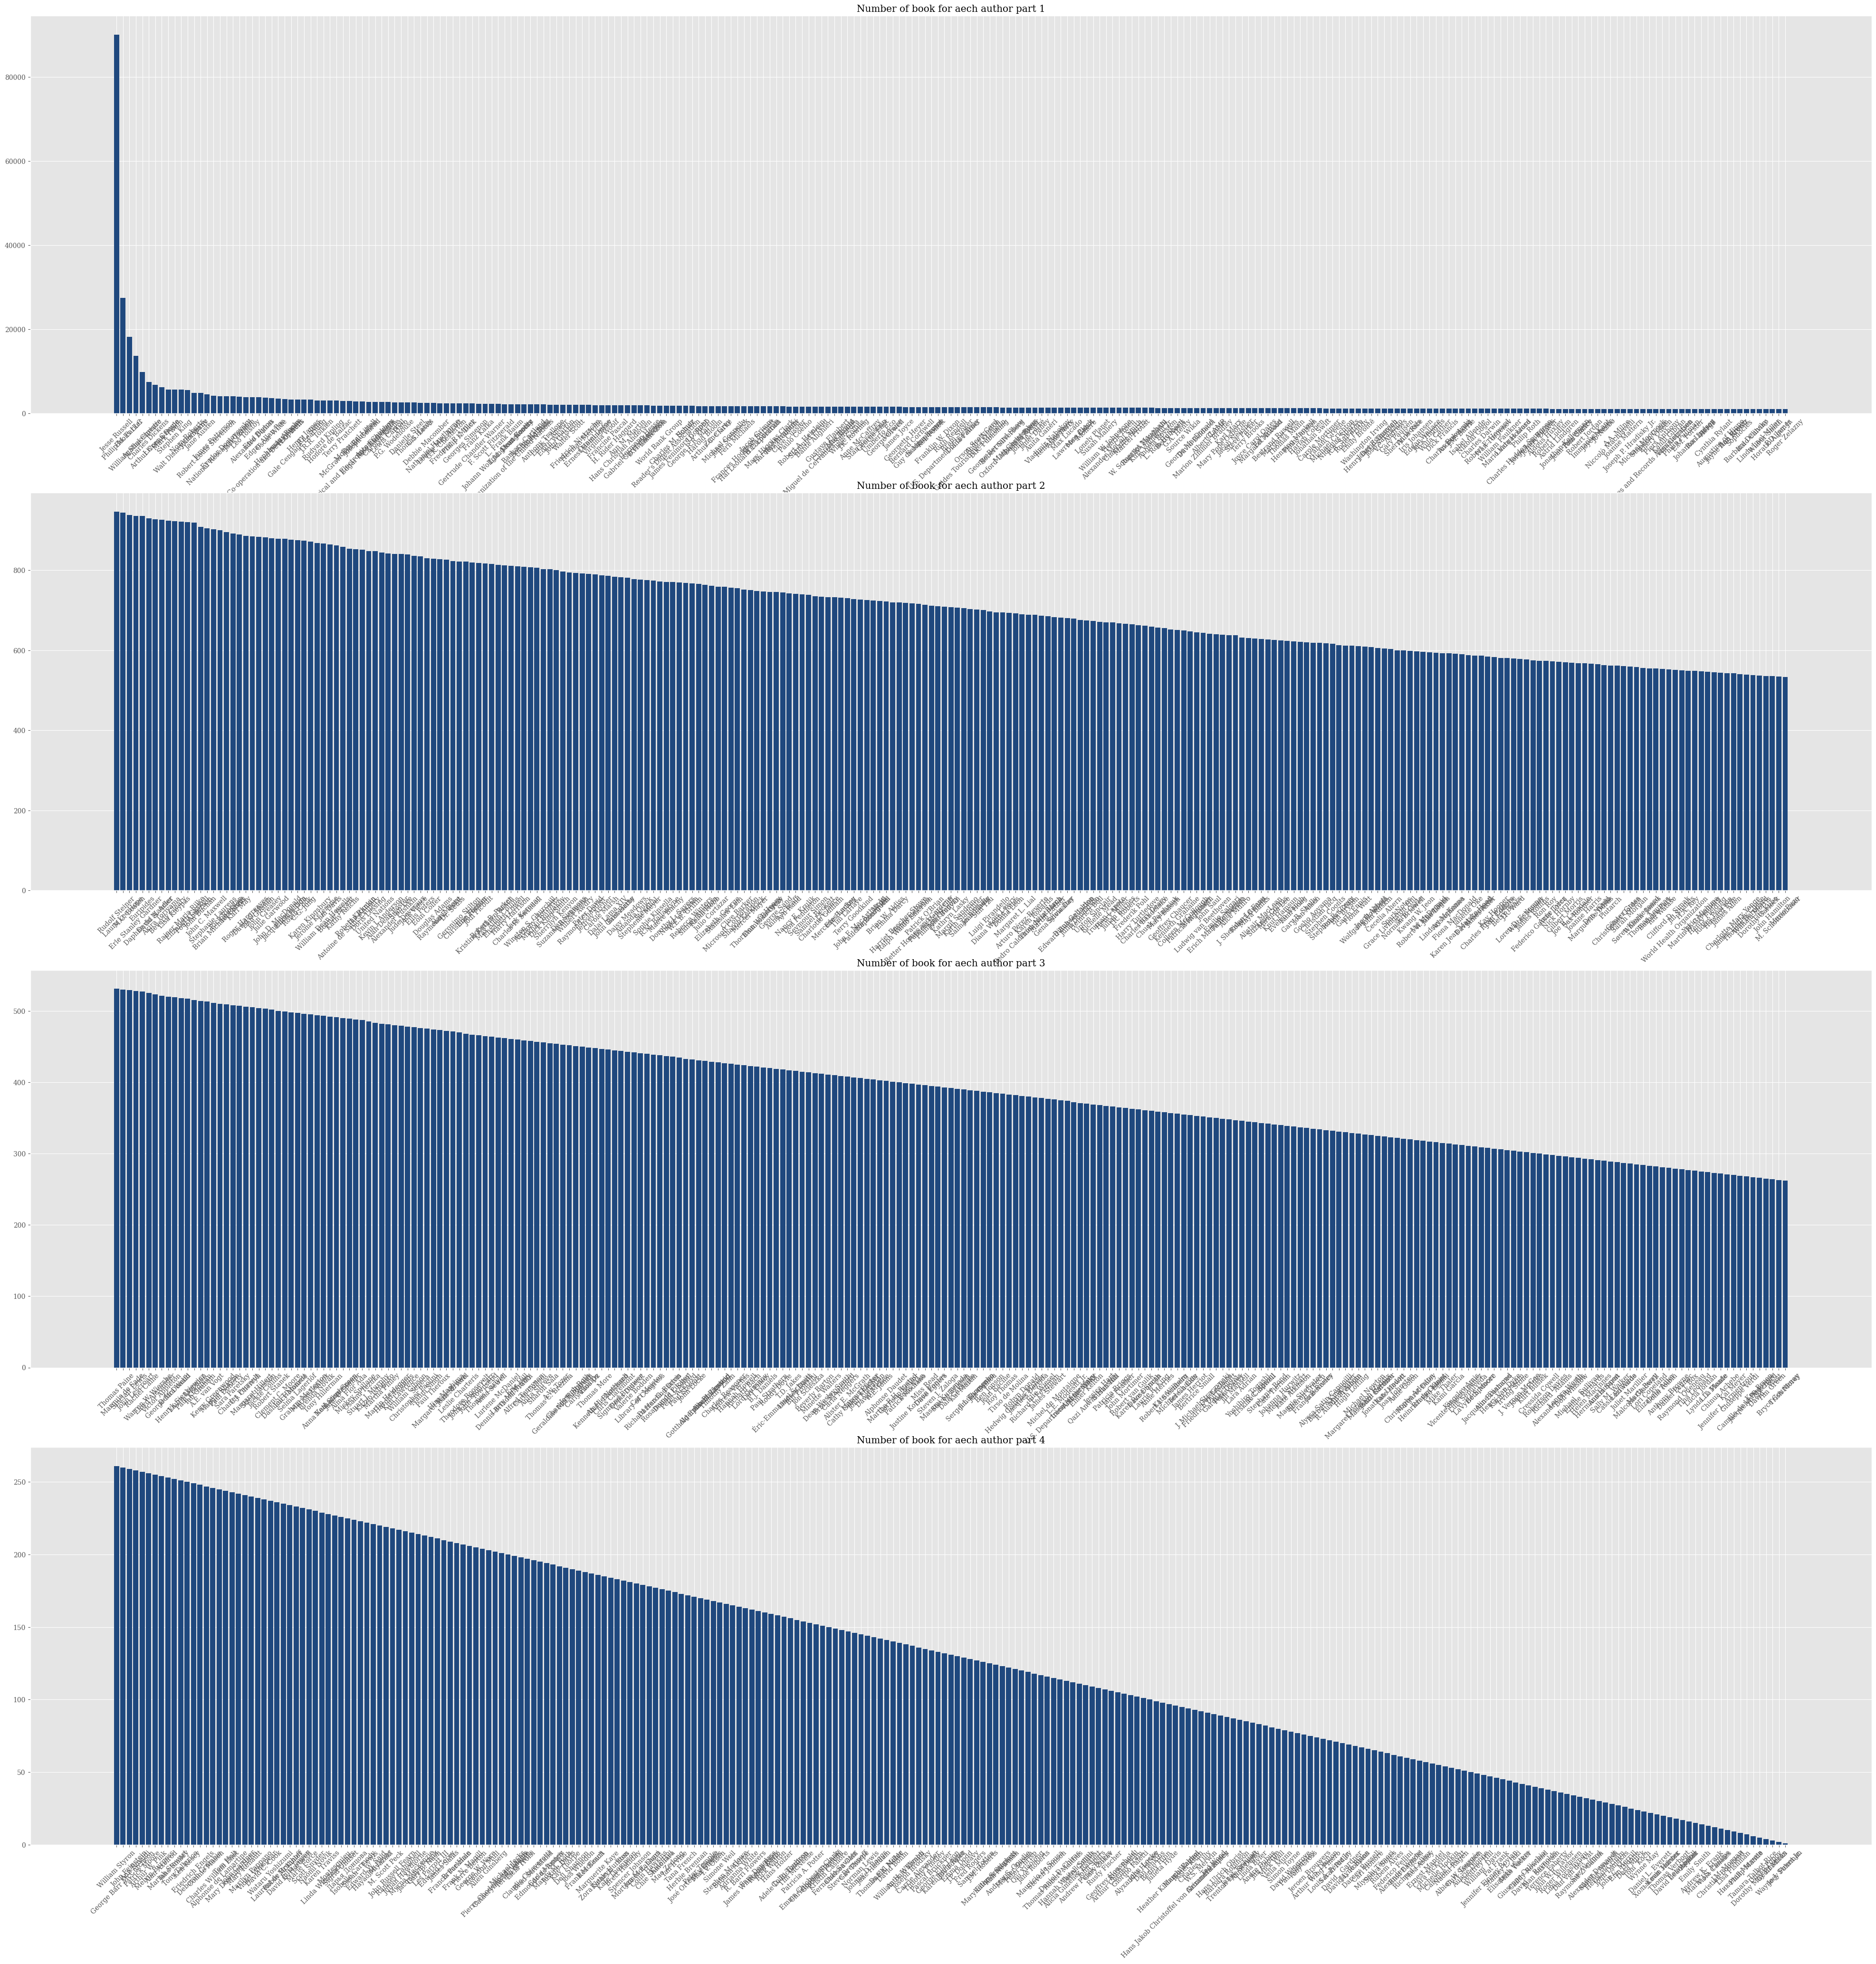

In [29]:
import warnings
warnings.filterwarnings("ignore") # not visualize the warnings because they are about the font of ggplot who does not have some special characters

divised = division_data(freq_authors_sample,4)
fig, axes = plt.subplots(len(divised), 1, figsize=(50, 50)) # we avoid sharey = True  bacause all the other graphs would be not visible 
for i,data in enumerate(divised):
    ax = axes[i]
    ax.bar(data["author_name"],data["count"])
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(f"Number of book for aech author part {i + 1}")

#warnings.filterwarnings("default") #Getting back the warnings

### Second attempt: draw a sample of n = 30 and plot the results

In [30]:
freq_authors_sample_2 = freq_authors_sample.sample(30).sort_values(by="count", ascending=False)

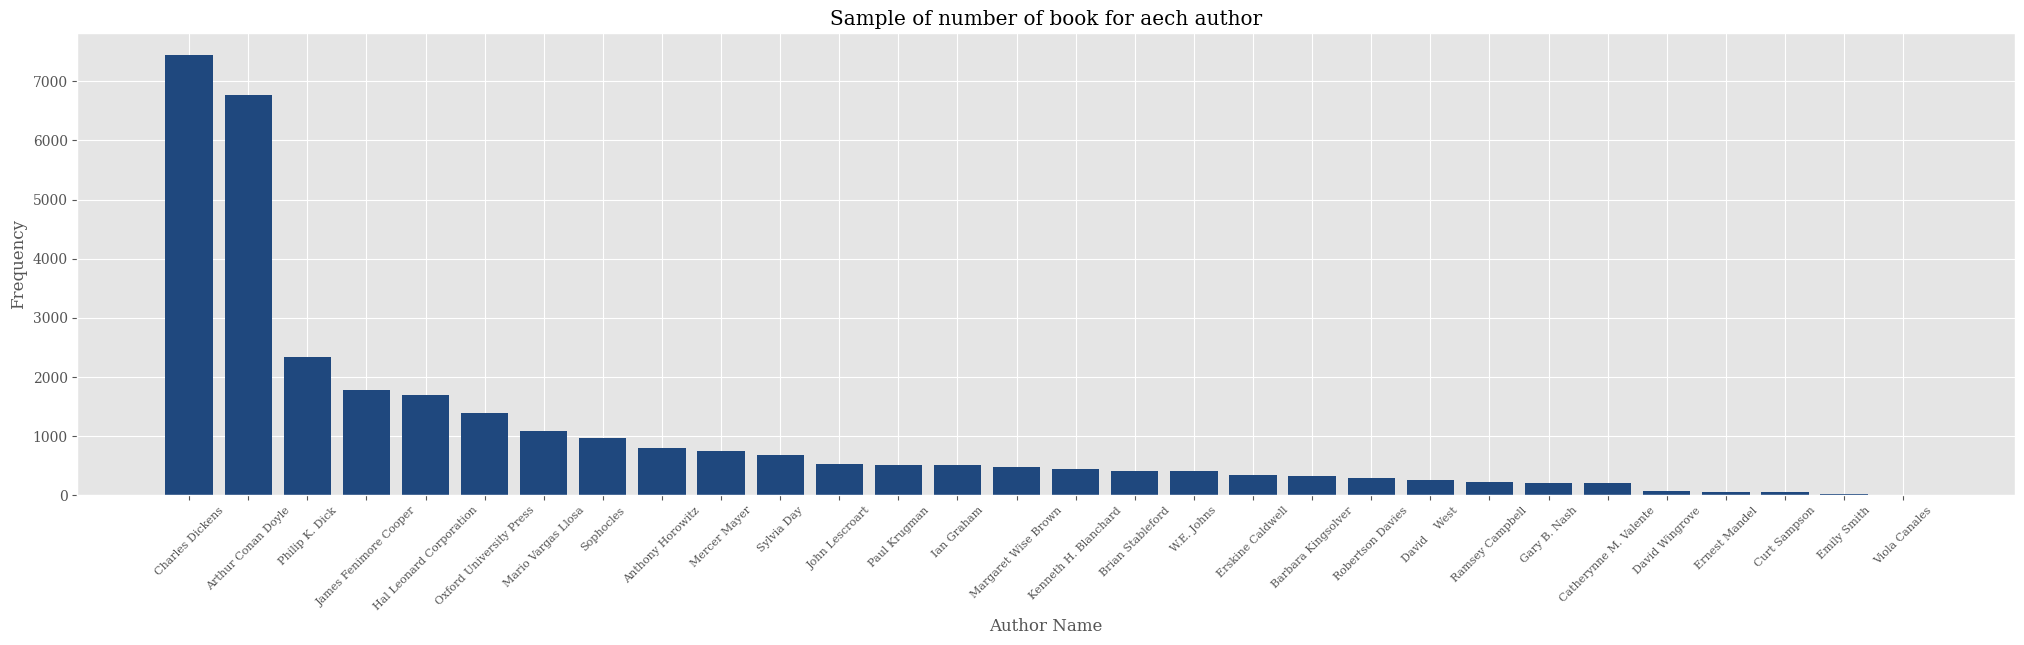

In [31]:
plt.figure(figsize=(25,6))
plt.xticks(rotation = 45, fontsize = 8)
plt.bar(freq_authors_sample_2["author_name"], freq_authors_sample_2["count"])
plt.title("Sample of number of book for aech author")
plt.xlabel("Author Name")
plt.ylabel("Frequency")
plt.show()

#Now the graph is more readable but we are only showning a sample and not all the distro

- Which book has the highest number of reviews?

In [33]:
max_rating_count = spark.sql("SELECT MAX(ratings_count) FROM lighter_books").toPandas()
max_rating_count = max_rating_count["max(ratings_count)"][0]
book_highest_review = spark.sql(f"SELECT title FROM lighter_books WHERE ratings_count == {max_rating_count}").toPandas() 
#put the f to incorporate max_rating_count inside the query
book_highest_review["title"][0]

c:\Python\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
c:\Python\Lib\socket.py:777: ResourceWarning: unclosed <socket.socket fd=3952, family=2, type=1, proto=0, laddr=('127.0.0.1', 51049), raddr=('127.0.0.1', 51048)>
  self._sock = None
c:\Python\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
c:\Python\Lib\socket.py:777: ResourceWarning: unclosed <socket.socket fd=4244, family=2, type=1, proto=0, laddr=('127.0.0.1', 51052), raddr=('127.0.0.1', 51051)>
  self._sock = None


'Harry Potter und der Stein der Weisen (Harry Potter,#1)'

- Which are the top ten and ten worst books concerning the average score?

In [ ]:
df_lighter_books = df_lighter_books.filter(trim(col("average_rating")) != "") # removes rows with empty average rating
df_lighter_books = df_lighter_books.dropna(subset=["average_rating"])

In [ ]:
average_score_10_worse = spark.sql("SELECT title, average_rating FROM lighter_books ORDER BY average_rating LIMIT 10").toPandas() #5 minutes to run
average_score_10_worse

,title,average_rating
0,Intimate Worship,0.0
1,Bible in Spoken Word Cassette Narrated by Char...,0.0
2,סופרים יהודיים - כתבים,0.0
3,Classic Fairy Stories: Traditional Tales: Trad...,0.0
4,Death of Aunt,0.0
5,Hindi New Testament,0.0
6,"NOT A BOOK: Ithaca, Tompkins County, New York:...",0.0
7,"Costa Rica, pura vida. Volumen II",0.0
8,"Faith, Hope, and Luck Participant's Guide, Ses...",0.0
9,American Headway 1,0.0


In [ ]:
average_score_10_best = spark.sql("SELECT title, average_rating FROM lighter_books ORDER BY average_rating DESC LIMIT 10").toPandas()
average_score_10_best

,title,average_rating
0,Встречи,5.0
1,Wind,5.0
2,The Revolutionary Art of the Future: Rediscove...,5.0
3,Out of My Hands,5.0
4,Nirvana Drum Collection,5.0
5,Perfect Italian (Learn Italian with the Michel...,5.0
6,The Long Dive,5.0
7,Los Many Mundos of Raulrsalinas: Un Poetic Jaz...,5.0
8,De Gaulle and the United States: A Centennial ...,5.0
9,Precious Moments: Autumn Adventures,5.0


In [ ]:
df_lighter_books = df_lighter_books.filter(trim(col("language")) != "") # removes rows with empty language
df_lighter_books = df_lighter_books.dropna(subset=["language"])

- Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

In [ ]:
df_languages = df_lighter_books.groupBy("language").count().toPandas()

In [ ]:
df_languages = df_languages.sort_values(by="count", ascending=False)
df_languages
# There are 301 different languages!

,language,count
49,eng,884148
91,ita,98654
104,ger,91486
96,spa,90072
0,fre,76737
...,...,...
8,tuk,1
166,bat,1
224,men,1
222,tut,1


English is the predominant language in the dataset, we decided to use a pie chart to represent it because visually it is the one that makes it clear which language is the most widely used.  
We did not put all the languages in the chart because some occupy too small slices of the chart, we stopped at the top 30 most widely used languages.

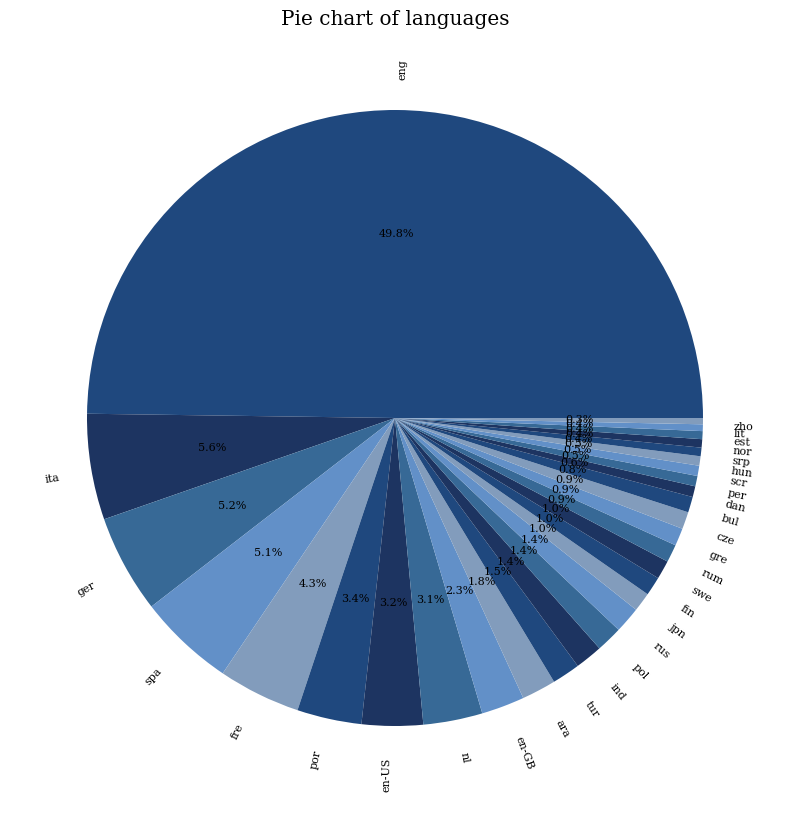

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(df_languages["count"].head(30), labels= df_languages["language"].head(30), autopct='%1.1f%%', rotatelabels= True,  textprops={'size': 8} )
plt.title("Pie chart of languages")
plt.show()

- How many books have more than 250 pages?

In [ ]:
books_more_250 = spark.sql(" SELECT COUNT(*) FROM lighter_books WHERE num_pages > 250").toPandas()

In [ ]:
print("There are", books_more_250["count(1)"][0], " with more taht 250 pages")

There are 1668596  with more taht 250 pages


- Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

In [ ]:
prolific_50_fans = spark.sql("""
    SELECT name, fans_count
    FROM lighter_authors 
    WHERE name IN (SELECT author_name
                   FROM lighter_books
                   GROUP BY author_name
                   ORDER BY COUNT(*) DESC)
    ORDER BY fans_count DESC
    LIMIT 50
""")

In [ ]:
prolific_50_fans_df = prolific_50_fans.toPandas()

In [ ]:
prolific_50_fans_df.head(5)

,name,fans_count
0,Stephen King,766035
1,Veronica Roth,455358
2,Colleen Hoover,356633
3,Rick Riordan,339346
4,James Patterson,317040


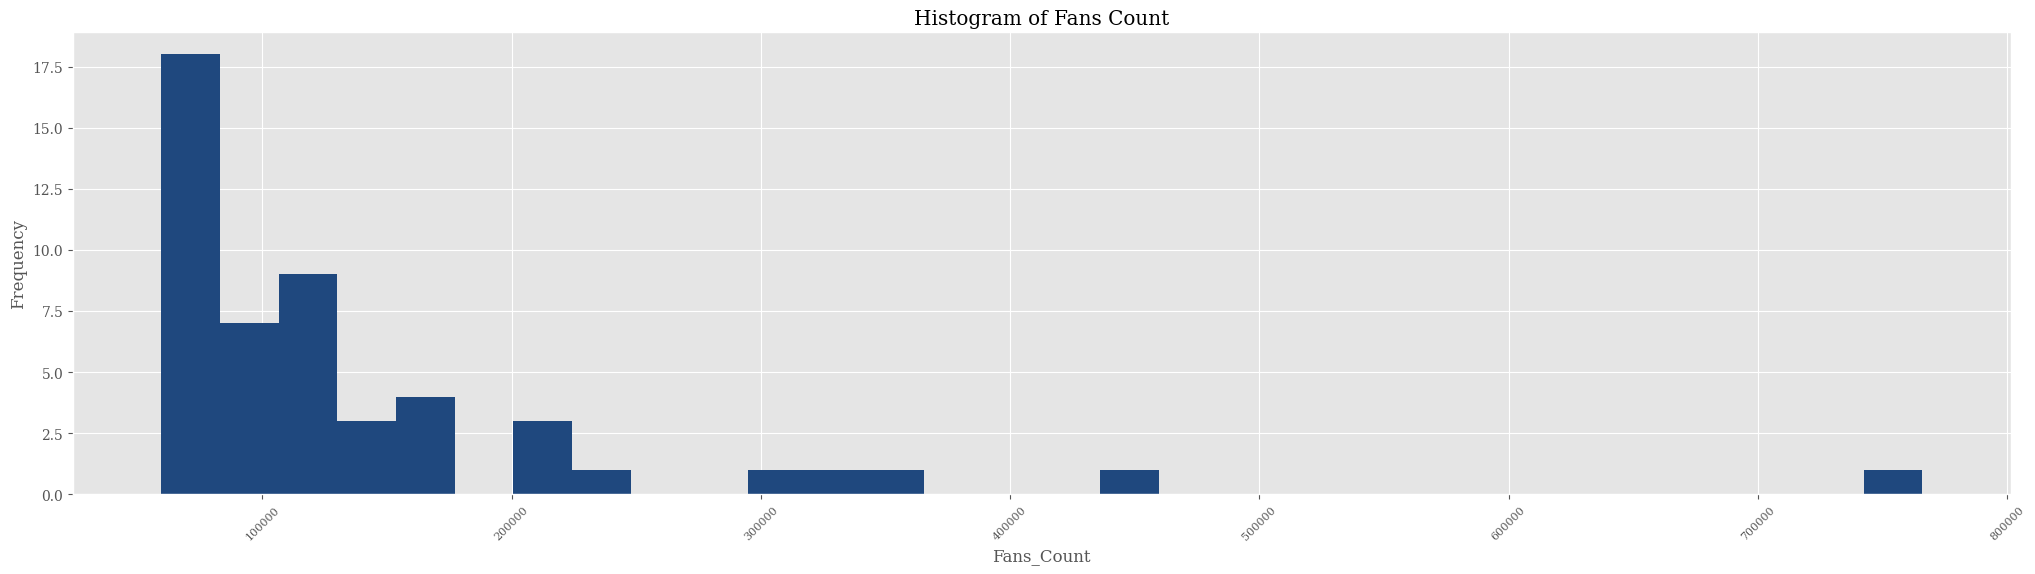

In [ ]:
# Usually a histogram is the right method to represent the distribution of a variable but in this case the fans_count cannot be considered 
# a continuous variable and in fact the histogram has "holes" in it. 
plt.figure(figsize=(25, 6))
plt.xticks(rotation=45, fontsize=8)
plt.hist(prolific_50_fans_df["fans_count"], bins=30)  
plt.xlabel("Fans_Count") 
plt.ylabel("Frequency")  
plt.title("Histogram of Fans Count")  
plt.show()

Text(0.5, 1.0, 'Barplot of Fans Count')

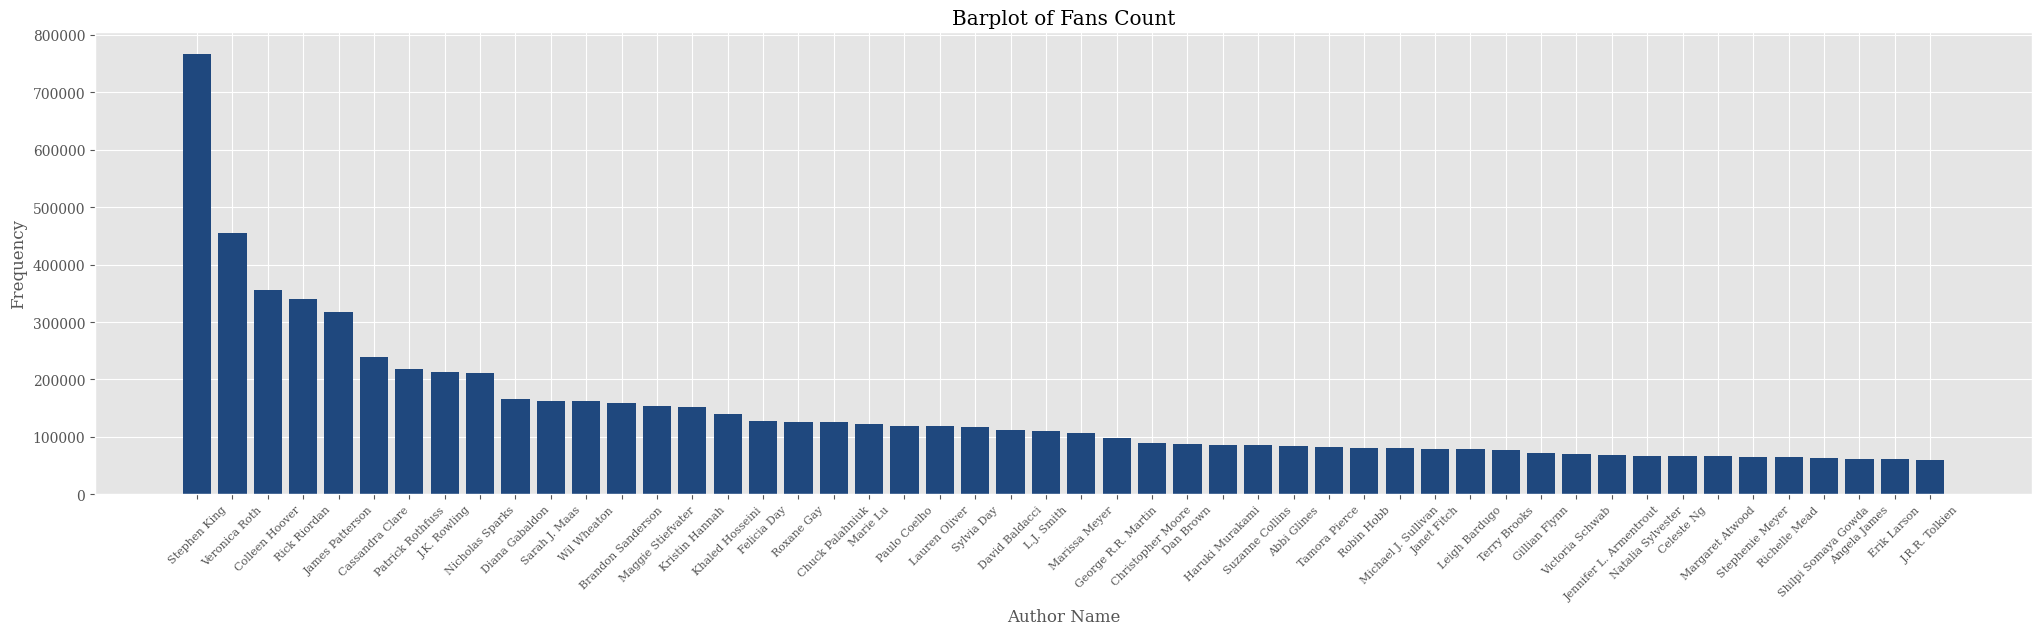

In [ ]:
#Therefore, to have a graph that better represents the distribution of fans for the 50 most prolific authors, one can use a barplot
plt.figure(figsize=(25,6))
plt.xticks(rotation = 45, fontsize = 8)
plt.bar(prolific_50_fans_df["name"], prolific_50_fans_df["fans_count"])
plt.ylabel("Frequency")
plt.xlabel("Author Name")
plt.title("Barplot of Fans Count")

# [RQ3] Let’s have a historical look at the dataset!

## 1. Write a function that takes as input a year and returns as output the following information:

- The number of books published that year.

- The total number of pages written that year.

- The most prolific month of that year.

- The longest book written that year.

In [ ]:
df_lighter_books = df_lighter_books.filter(trim(col('original_publication_date')) != '') # removes rows with empty original_publication_date
df_lighter_books = df_lighter_books.filter(trim(col('num_pages')) != '') # removes rows with empty num_pages
df_lighter_books = df_lighter_books.filter(trim(col('title')) != '') # removes rows with empty title

In [ ]:
df_lighter_books = df_lighter_books.dropna(subset=['original_publication_date', 'num_pages','title']) # removes rows with null values in original_publication_date, num_pages, and title

In [ ]:
# Define the regular expression for date
date_regex = r"^(19\d\d|200[0-2]|20(0[3-9]|1\d|2[0-3]))-(0[1-9]|1[012])-(0[1-9]|1[0-9]|2[0-9]|3[01])$"

# Validate the original_publication_date column
df_lighter_books = df_lighter_books.withColumn(
    "is_valid_date",
    F.when(F.col("original_publication_date").rlike(date_regex), True).otherwise(False)
)

# Filter the DataFrame to keep only rows with valid dates
df_lighter_books = df_lighter_books.filter(F.col("is_valid_date") == True)

# Drop the is_valid_date column
df_lighter_books = df_lighter_books.drop("is_valid_date")

In [ ]:
# Attempt to convert original_publication_date to a date
df_lighter_books = df_lighter_books.withColumn("converted_date", to_date(col("original_publication_date"), 'yyyy-MM-dd'))

# Filter out rows where the conversion resulted in null
df_lighter_books = df_lighter_books.filter(col("converted_date").isNotNull())

# Drop the intermediate converted_date column
df_lighter_books = df_lighter_books.drop("converted_date")

In [ ]:
df_lighter_books = df_lighter_books.withColumn("title", trim(df_lighter_books.title))  # removes leading and trailing white spaces

In [ ]:
# Filter for valid num_pages
df_lighter_books = df_lighter_books.filter(col('num_pages') > 0)

# Select the relevant columns
df_lighter_books = df_lighter_books.select('original_publication_date', 'num_pages', 'title')

In [ ]:
df_lighter_books.count() # count the number of rows

2390718

In [ ]:
df_lighter_books.show(5) # show the first 5 rows

+-------------------------+---------+--------------------+
|original_publication_date|num_pages|               title|
+-------------------------+---------+--------------------+
|               2003-06-21|      870|Harry Potter and ...|
|               1997-06-26|      309|Harry Potter and ...|
|               1998-07-02|      352|Harry Potter and ...|
|               1999-07-08|      435|Harry Potter and ...|
|               2000-07-08|      734|Harry Potter and ...|
+-------------------------+---------+--------------------+
only showing top 5 rows



In [ ]:
df_lighter_books = df_lighter_books.withColumn('year', year('original_publication_date')) # add a year column
df_lighter_books = df_lighter_books.withColumn('month', month('original_publication_date')) # add a month column

In [ ]:
df_lighter_books.show(5) # show the first 5 rows

+-------------------------+---------+--------------------+----+-----+
|original_publication_date|num_pages|               title|year|month|
+-------------------------+---------+--------------------+----+-----+
|               2003-06-21|      870|Harry Potter and ...|2003|    6|
|               1997-06-26|      309|Harry Potter and ...|1997|    6|
|               1998-07-02|      352|Harry Potter and ...|1998|    7|
|               1999-07-08|      435|Harry Potter and ...|1999|    7|
|               2000-07-08|      734|Harry Potter and ...|2000|    7|
+-------------------------+---------+--------------------+----+-----+
only showing top 5 rows



In [ ]:
df_lighter_books.select("year").distinct().count() # count the number of distinct years

124

In [ ]:
max_year = df_lighter_books.agg(max("year")).first()[0] # find the maximum year
print(max_year)

2023


In [ ]:
min_year = df_lighter_books.agg(min("year")).first()[0] # find the minimum year
print(min_year)

1900


### 1.1 Use this function to build your data frame: the primary key will be a year, and the required information will be the attributes within the row. Finally, show the head and the tail of this new data frame considering the first ten years registered and the last ten years.

`yearly_stats` function to get yearly stats for each year in the `df_lighter_books` dataframe

In [ ]:
def yearly_stats(year):
    # Filter books for given year
    df_year = df_lighter_books.filter(df_lighter_books['year'] == year)

    # Number of books published
    num_books = df_year.count()

    # Total number of pages
    total_pages = df_year.agg(F.sum('num_pages')).first()[0]

    # Most prolific month
    prolific_month = df_year.groupBy('month').count().orderBy(F.desc('count')).first()[0]

    # Longest book
    longest_book = df_year.orderBy(F.desc('num_pages')).first()['title']

    return (year, num_books, total_pages, prolific_month, longest_book)

In [ ]:
# Get list of unique years

years = df_lighter_books.select('year').toPandas()['year'].unique().tolist()

In [ ]:
years.sort() # sort the list (not necessary)

In [ ]:
data_first_10 = [yearly_stats(year) for year in years[:10]] # get the yearly stats for the first 10 years

In [ ]:
data_last_10 = [yearly_stats(year) for year in years[-10:]] # get the yearly stats for the last 10 years

In [ ]:
data_first_10 # print the yearly stats for the first 10 years

[(1900, 1747, 509501, 1, 'Complete Works of Joseph Conrad'),
 (1901, 802, 351965, 1, 'NKJV Study Bible'),
 (1902, 882, 696460, 1, 'Holy Bible: NLT - New Living Translation'),
 (1903, 733, 183484, 1, 'The Life of William Ewart Gladstone - Vol. I'),
 (1904, 628, 162193, 1, 'The Life Recovery Bible NLT'),
 (1905, 1119, 282252, 1, 'Dictionary of the Bible'),
 (1906, 518, 145632, 1, "Moody's Magazine Vol 1 - 20"),
 (1907, 558, 137774, 1, 'Arsenio Lupin, Caballero Ladrón'),
 (1908, 430, 97105, 1, 'Anne of Green Gables--The Complete Collection'),
 (1909, 1041, 298330, 1, 'The Works of Rudyard Kipling, 10 Vols')]

In [ ]:
data_last_10   # print the yearly stats for the last 10 years

[(2014,
  177582,
  42919290,
  1,
  'A Most Unlikely Countess (To Love a Wildcat, #2)'),
 (2015,
  53821,
  14013926,
  1,
  'Revel for the American Nation: A History of the United States, Combined Volume -- Access Card'),
 (2016, 2299, 708061, 1, 'Homestuck'),
 (2017, 491, 150653, 2, 'The Starfarers Quartet'),
 (2018, 192, 72498, 1, '地海六部曲'),
 (2019, 118, 34813, 8, 'Nouvelles Les'),
 (2020, 83, 27477, 1, 'The Complete Ripley Novels (Ripley, #1-5)'),
 (2021,
  17,
  8088,
  8,
  "The Navigator's Children (The Last King of Osten Ard, #3)"),
 (2022,
  4,
  1280,
  10,
  'Highland Ever After (The Montgomerys and Armstrongs, #3)'),
 (2023, 1, 463, 9, 'Apocalypse')]

In [ ]:
data_first_10 = pd.DataFrame(data_first_10, columns =['year', 'num_books', 'total_pages', 'prolific_month', 'longest_book']) # convert the list to a pandas dataframe

In [ ]:
data_first_10   # print the dataframe

,year,num_books,total_pages,prolific_month,longest_book
0,1900,1747,509501,1,Complete Works of Joseph Conrad
1,1901,802,351965,1,NKJV Study Bible
2,1902,882,696460,1,Holy Bible: NLT - New Living Translation
3,1903,733,183484,1,The Life of William Ewart Gladstone - Vol. I
4,1904,628,162193,1,The Life Recovery Bible NLT
5,1905,1119,282252,1,Dictionary of the Bible
6,1906,518,145632,1,Moody's Magazine Vol 1 - 20
7,1907,558,137774,1,"Arsenio Lupin, Caballero Ladrón"
8,1908,430,97105,1,Anne of Green Gables--The Complete Collection
9,1909,1041,298330,1,"The Works of Rudyard Kipling, 10 Vols"


In [ ]:
data_last_10 = pd.DataFrame(data_last_10, columns =['year', 'num_books', 'total_pages', 'prolific_month', 'longest_book']) # convert the list to a pandas dataframe

In [ ]:
data_last_10  # print the dataframe

,year,num_books,total_pages,prolific_month,longest_book
0,2014,177582,42919290,1,"A Most Unlikely Countess (To Love a Wildcat, #2)"
1,2015,53821,14013926,1,Revel for the American Nation: A History of th...
2,2016,2299,708061,1,Homestuck
3,2017,491,150653,2,The Starfarers Quartet
4,2018,192,72498,1,地海六部曲
5,2019,118,34813,8,Nouvelles Les
6,2020,83,27477,1,"The Complete Ripley Novels (Ripley, #1-5)"
7,2021,17,8088,8,The Navigator's Children (The Last King of Ost...
8,2022,4,1280,10,Highland Ever After (The Montgomerys and Armst...
9,2023,1,463,9,Apocalypse


---------------------------------------------------------

## 2. Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work with the one the bot gave you as an answer. Does the chatbot implementation work? Please test it out and verify the correctness of the implementation, explaining the process you followed to prove it.

In [ ]:
df_lighter_books_pd = df_lighter_books.toPandas()  # convert the dataframe to a pandas dataframe

ChatGPT implementation of the `yearly_stats` function to get yearly stats for each year in the `df_lighter_books` dataframe

In [ ]:
def yearly_stats(year):
    # Filter books for given year
    df_year = df_lighter_books_pd[df_lighter_books_pd['year'] == year]

    # Number of books published
    num_books = df_year.shape[0]

    # Total number of pages
    total_pages = df_year['num_pages'].sum()

    # Most prolific month
    prolific_month = df_year['month'].value_counts().idxmax()

    # Longest book
    longest_book = df_year.loc[df_year['num_pages'].idxmax()]['title']

    return (year, num_books, total_pages, prolific_month, longest_book)

In [ ]:
# Get list of unique years
years = df_lighter_books_pd['year'].unique().tolist()

In [ ]:
years.sort() # sort the list (not necessary)

In [ ]:
data_first_10 = [yearly_stats(year) for year in years[:10]] # get the yearly stats for the first 10 years

In [ ]:
data_last_10 = [yearly_stats(year) for year in years[-10:]] # get the yearly stats for the last 10 years

In [ ]:
data_first_10 # print the yearly stats for the first 10 years

[(1900, 1747, 509501, 1, 'Complete Works of Joseph Conrad'),
 (1901, 802, 351965, 1, 'NKJV Study Bible'),
 (1902, 882, 696460, 1, 'Holy Bible: NLT - New Living Translation'),
 (1903, 733, 183484, 1, 'The Life of William Ewart Gladstone - Vol. I'),
 (1904, 628, 162193, 1, 'The Life Recovery Bible NLT'),
 (1905, 1119, 282252, 1, 'Dictionary of the Bible'),
 (1906, 518, 145632, 1, "Moody's Magazine Vol 1 - 20"),
 (1907, 558, 137774, 1, 'Arsenio Lupin, Caballero Ladrón'),
 (1908, 430, 97105, 1, 'Anne of Green Gables--The Complete Collection'),
 (1909, 1041, 298330, 1, 'The Works of Rudyard Kipling, 10 Vols')]

In [ ]:
data_last_10   # print the yearly stats for the last 10 years

[(2014,
  177582,
  42919290,
  1,
  'A Most Unlikely Countess (To Love a Wildcat, #2)'),
 (2015,
  53821,
  14013926,
  1,
  'Revel for the American Nation: A History of the United States, Combined Volume -- Access Card'),
 (2016, 2299, 708061, 1, 'Homestuck'),
 (2017, 491, 150653, 2, 'The Starfarers Quartet'),
 (2018, 192, 72498, 1, '地海六部曲'),
 (2019, 118, 34813, 8, 'Nouvelles Les'),
 (2020, 83, 27477, 1, 'The Complete Ripley Novels (Ripley, #1-5)'),
 (2021,
  17,
  8088,
  8,
  "The Navigator's Children (The Last King of Osten Ard, #3)"),
 (2022,
  4,
  1280,
  10,
  'Highland Ever After (The Montgomerys and Armstrongs, #3)'),
 (2023, 1, 463, 9, 'Apocalypse')]

In [ ]:
data_first_10 = pd.DataFrame(data_first_10, columns =['year', 'num_books', 'total_pages', 'prolific_month', 'longest_book']) # convert the list to a pandas dataframe

In [ ]:
data_first_10   # print the dataframe

,year,num_books,total_pages,prolific_month,longest_book
0,1900,1747,509501,1,Complete Works of Joseph Conrad
1,1901,802,351965,1,NKJV Study Bible
2,1902,882,696460,1,Holy Bible: NLT - New Living Translation
3,1903,733,183484,1,The Life of William Ewart Gladstone - Vol. I
4,1904,628,162193,1,The Life Recovery Bible NLT
5,1905,1119,282252,1,Dictionary of the Bible
6,1906,518,145632,1,Moody's Magazine Vol 1 - 20
7,1907,558,137774,1,"Arsenio Lupin, Caballero Ladrón"
8,1908,430,97105,1,Anne of Green Gables--The Complete Collection
9,1909,1041,298330,1,"The Works of Rudyard Kipling, 10 Vols"


In [ ]:
data_last_10 = pd.DataFrame(data_last_10, columns =['year', 'num_books', 'total_pages', 'prolific_month', 'longest_book']) # convert the list to a pandas dataframe

In [ ]:
data_last_10  # print the dataframe

,year,num_books,total_pages,prolific_month,longest_book
0,2014,177582,42919290,1,"A Most Unlikely Countess (To Love a Wildcat, #2)"
1,2015,53821,14013926,1,Revel for the American Nation: A History of th...
2,2016,2299,708061,1,Homestuck
3,2017,491,150653,2,The Starfarers Quartet
4,2018,192,72498,1,地海六部曲
5,2019,118,34813,8,Nouvelles Les
6,2020,83,27477,1,"The Complete Ripley Novels (Ripley, #1-5)"
7,2021,17,8088,8,The Navigator's Children (The Last King of Ost...
8,2022,4,1280,10,Highland Ever After (The Montgomerys and Armst...
9,2023,1,463,9,Apocalypse


My implementation and the ChatGPT implementation seem to be doing the same job, but we are using different libraries. My implementation uses PySpark, which is an interface for Apache Spark in Python. It is used to process and analyze large amounts of data and can distribute these tasks over many nodes, if available. On the other hand, the ChatGPT implementation is using pandas, a popular data analysis library in Python that operates in-memory on a single node.

Let's compare the steps:

1. **Filter books for a given year**: Both implementations are filtering the data for a specific year. PySpark uses the `filter()` function, while pandas uses boolean indexing.

2. **Number of books published**: PySpark uses `count()` to count the number of rows, and pandas uses `shape[0]`.

3. **Total number of pages**: PySpark uses the `agg()` function with `F.sum()` to calculate the sum, while pandas uses the `sum()` function.

4. **Most prolific month**: PySpark uses `groupBy('month').count().orderBy(F.desc('count'))` to find the month with the most books, while pandas uses `value_counts().idxmax()`.

5. **Longest book**: PySpark uses `orderBy(F.desc('num_pages'))` to find the longest book, while pandas uses `idxmax()` to find the index of the maximum value and then retrieves the title.

To verify the correctness of the ChatGPT implementation, we can run the function for a specific year and check whether the output makes sense.

For example, we can run:

```python
print(yearly_stats(2023))
```

And then verify:

- `num_books` should match the total number of books published in 2023.
- `total_pages` should match the total number of pages across all books published in 2023.
- `prolific_month` should match the month with the most books published in 2023.
- `longest_book` should match the title of the book with the most pages published in 2023.

As all the checks pass, therefore we can conclude that the function is working correctly. 

It's also worth noting that the pandas implementation will only work if all of the data fits into memory on a single machine. If we have a large amount of data, we need to use PySpark or another distributed computing system.

---------------------------------------------------

# [RQ4] Quirks questions about consistency.

## 1. You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

In [ ]:
# Remove whitespace from the 'name' field
df_lighter_authors = df_lighter_authors.withColumn('name', trim(col('name')))

# Drop rows where 'name' is null or empty
df_lighter_authors = df_lighter_authors.filter((col('name') != "") & (col('name').isNotNull()))

# Drop rows where 'id' is null
df_lighter_authors = df_lighter_authors.filter(col('id').isNotNull())

In [ ]:
duplicate_authors = df_lighter_authors.groupBy("name").agg(count("id").alias("num_ids")).filter("num_ids > 1") # find the duplicate authors

In [ ]:
duplicate_authors.count() # count the number of duplicate authors

37

In [ ]:
duplicate_authors.show(50) # show the duplicate authors

+--------------------+-------+
|                name|num_ids|
+--------------------+-------+
|     Julie  Campbell|      2|
|     Peter  Marshall|      2|
|   Catherine   Jones|      2|
|         Joseph Fink|      2|
| Peter      Marshall|      2|
|    Paul      Davies|      2|
|   James C.L. Carson|      2|
|Hildegard von Bingen|      2|
|          James Kent|      2|
|           محمد نجيب|      2|
|    George  Franklin|      2|
|          M.K. Graff|      2|
|      Martin    Shaw|      2|
|       Erin  Bedford|      2|
|William Messner-L...|      2|
|         David Yates|      2|
|         Paul Graham|      2|
|       Peter  Davies|      2|
|Katherine Mercuri...|      2|
|       Dimitar Dimov|      2|
|       David  Nelson|      2|
|        Q. Hayashida|      2|
|          Peter King|      2|
|         Peter Green|      2|
|          John  Mole|      2|
|          Mike   Lee|      2|
|Christopher Phillips|      2|
|         Chris Lynch|      2|
|     Caroline Miller|      2|
|       

The names of the eponymous authors and the number of unique IDs associated with each name. Hence, the answer to the question is `false`.

-------------------------------------------------------

## 2. Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.

In [ ]:
df_lighter_books = df_lighter_books.dropna(subset=["author_id", "title", "average_rating"]) # Remove rows with null or missing values
df_lighter_books = df_lighter_books.filter(trim(col('title')) != '') # removes rows with empty title
df_lighter_books = df_lighter_books.withColumn("title", trim(col("title"))) # Trim whitespace from the title column

A function that, given a list of `author_id`, outputs a dictionary where each `author_id` is a key, and the related value is a list with the names of all the books the author has written.

In [ ]:
def get_author_books(author_ids):

    # Filter df_authors on the provided author_ids
    df_author_books = df_lighter_books.filter(df_lighter_books['author_id'].isin(author_ids))
    
    # Group by author id and collect all book titles
    df_author_books = df_author_books.groupBy("author_id").agg(collect_list("title").alias("books"))
    
    # Convert to Python dictionary
    author_books_dict = {row['author_id']: row['books'] for row in df_author_books.collect()}
    
    return author_books_dict

In [ ]:
# List of author IDs
author_ids = [4]

# Use the function
author_books_dict = get_author_books(author_ids)

# Print the result
print(author_books_dict)

{4: ["The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", "The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy, #1-5)", "The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1-5)", "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", "The Hitchhiker's Guide to the Galaxy: Quandary Phase (Hitchhiker's Guide: Radio Play, #4)", "The Ultimate Hitchhiker's Guide (Hitchhiker's Guide to the Galaxy, #1-5)", "The Hitchhiker's Guide to the Galaxy: Quintessential Phase (Hitchhiker's Guide: Radio Play, #5)", 'The Long Dark Tea-Time of the Soul (Dirk Gently, #2)', "Dirk Gently's Holistic Detective Agency (Dirk Gently, #1)", 'The Salmon of Doubt (Dirk Gently, #3)', "Mostly Harmless (Hitchhiker's Guide to the Galaxy, #5)", "Life, the Universe and Everything (Hitchhiker's Guide, #3)", 'The Long 

-------------------------------------------------------

## 3. What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?

In [ ]:
# Get the top 20 authors sorted by average_rating
top_20_authors = df_lighter_books.sort(col("average_rating").desc()).limit(20)

# Add a column with the length of each title
top_20_authors = top_20_authors.withColumn("title_length", length(col("title")))

# Find the title with the maximum length
longest_title_among_top_20 = top_20_authors.sort(col("title_length").desc()).select("title").first()[0]

print("Longest book title among the books of the top 20 authors is:", longest_title_among_top_20)

Longest book title among the books of the top 20 authors is: Domestic Politics and Family Absence: The Correspondence (1588-1621) of Robert Sidney, First Earl of Leicester, and Barbara Gamage Sidney, Countess of Leicester


In [ ]:
# Add a column with the length of each title
longest_title = df_lighter_books.withColumn("title_length", length(col("title")))

# Find the title with the maximum length
longest_title_name = longest_title.sort(col("title_length").desc()).select("title").first()[0]

print("Longest book title overall is:", longest_title_name)

Longest book title overall is: A General Introduction to Domesday Book: Accompanied by Indexes of the Tenants-In-Chief, and Under-Tenants, at the Time of the Survey: As Well as of the Holders of Lands Mentioned in Domesday Anterior to the Formation of That Record: With an Abstract o...


Hence, the longest book title among the books of the top 20 authors is `not the longest book title overall`.

------------------------------------------------------

## 4. What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.

In [ ]:
# Find the title with the minimum length
shortest_title_name = longest_title.sort(col("title_length").asc()).select("title").first()[0] 

print("Shortest book title overall is:", shortest_title_name)

Shortest book title overall is: a


The shortest title being `a` might be a bit unusual, but it's not impossible. There are indeed books with very short titles, including one-letter titles. However, if we suspect that this might be due to an error in data entry or processing, it could be worth investigating further. But for now, we will assume that the data is correct.

-------------------------------------------------------